In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score
from clusterless import preprocess

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### prepare data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y.argmax(1)
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_trial_ids, test_trial_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_trial_ids, train_t_ids, \
               test_trials, test_trial_ids, test_t_ids
    
    
    def compute_lambda(self, gmm):
        C = len(gmm.means_)
        lambdas = []
        for k in self.train_ids:
            lam_lst = []
            for t in range(self.n_t_bins):
                t_bin = self.trials[k][t]
                cluster_ids = gmm.predict(t_bin)
                lam = np.zeros((C, 2))
                for j in range(C):
                    if self.y[k] == 0:
                        lam[j, 0] = np.sum(cluster_ids == j)
                    else:
                        lam[j, 1] = np.sum(cluster_ids == j)
                lam_lst.append(lam)
            lambdas.append(lam_lst)
        n_left, n_right = np.sum(self.y_train == 0), np.sum(self.y_train == 1)
        p = n_right / (n_right + n_left)
        lambdas = ( np.array(lambdas).sum(0) / np.array([n_left, n_right]) ).transpose(1,0,2)
        return lambdas, p 

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = choices, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=10)

In [8]:
train_trials, train_trial_ids, train_t_ids, \
test_trials, test_trial_ids, test_t_ids = data_loader.split_train_test(split=.8)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
C = 10
gmm = GaussianMixture(n_components = C, 
                      covariance_type = 'full', 
                      init_params = 'k-means++',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(init_params='k-means++', n_components=10, verbose=1)

In [10]:
lambdas, p = data_loader.compute_lambda(gmm)

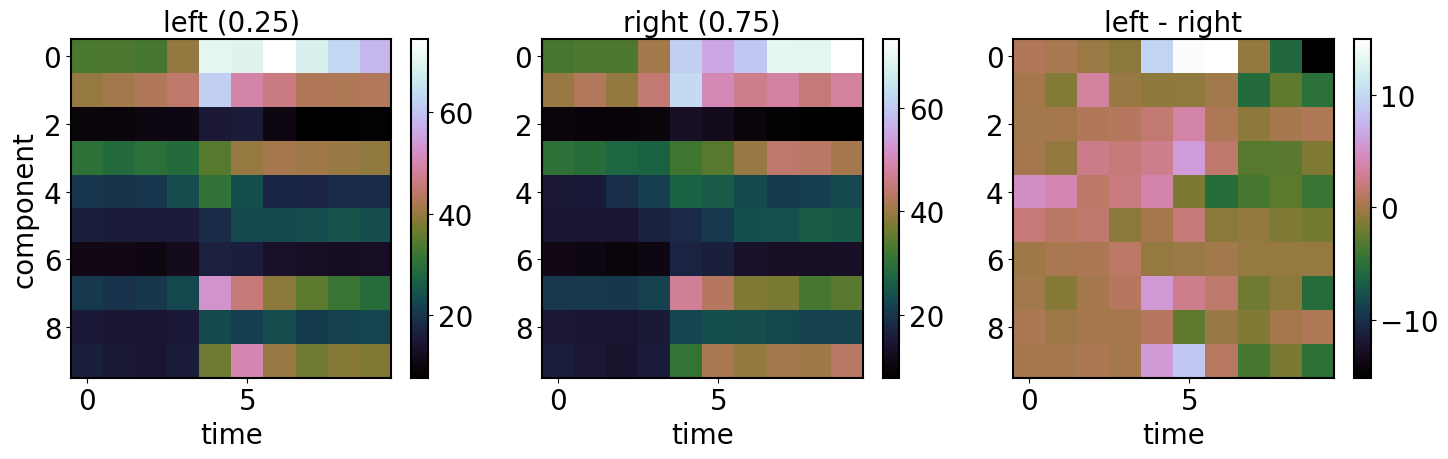

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(lambdas[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left ({p:.2f})')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right ({1-p:.2f})')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(lambdas[:,:,0] - lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()

#### CAVI

In [12]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

def safe_divide(x, y):
    return torch.clip(x / y, min = 0, max = 1)

In [89]:
class CAVI():
    def __init__(self, init_mu, init_cov, init_lam, 
                 train_k_ids, train_t_ids, test_k_ids, test_t_ids):
        
        self.train_K = len(train_k_ids)
        self.test_K = len(test_k_ids)
        self.T = len(train_t_ids)
        self.C = init_mu.shape[0]
        self.D = init_mu.shape[1]
        self.init_mu = init_mu
        self.init_cov = init_cov
        self.init_lam = init_lam
        self.train_k_ids = train_k_ids
        self.train_t_ids = train_t_ids
        self.test_k_ids = test_k_ids
        self.test_t_ids = test_t_ids
        
    
    def _compute_normal_log_dens(self, s, mu, cov):
        
        log_dens = []
        for j in range(self.C):
            log_dens.append(
                torch.tensor(
                    multivariate_normal.logpdf(s, mu[j], cov[j])
                )
            )
        return torch.vstack(log_dens).T # (*, C)
    
    
    def _compute_enc_elbo(self, r, y, log_dens, norm_lam):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           y[self.train_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           1-y[self.train_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo = elbo_1 + elbo_2 + elbo_3 

        return elbo
    
    
    def _compute_dec_elbo(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           nu[self.test_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           1-nu[self.test_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = torch.sum(nu_k * safe_log(p) + (1-nu_k) * safe_log(1-p))

        elbo_4 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo_5 = - torch.sum(safe_log(nu_k) * nu_k)

        elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5

        return elbo
    
    
    def _encode_e_step(self, r, y, log_dens, norm_lam):
        
        for t in range(self.T):
            r[self.train_t_ids[t]] = torch.exp( log_dens[self.train_t_ids[t]] + \
                      torch.einsum('il,j->ij', y[self.train_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-y[self.train_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.train_t_ids[t]] = torch.einsum('ij,i->ij', r[self.train_t_ids[t]], 1/r[self.train_t_ids[t]].sum(1))
        return r
        
    
    def _encode_m_step(self, s, r, y, mu, lam):
        
        for j in range(self.C):
            no_j_idx = torch.cat([torch.arange(j), torch.arange(j+1, self.C)])
            lam_sum_no_j = lam[no_j_idx,:,:].sum(0)
            for t in range(self.T):
                num1 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], y[self.train_t_ids[t]], lam_sum_no_j[t,1])
                denom1 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], y[self.train_t_ids[t]])
                num0 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], 1-y[self.train_t_ids[t]], lam_sum_no_j[t,0])
                denom0 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], 1-y[self.train_t_ids[t]])
                lam[j,t,1], lam[j,t,0] = num1 / denom1, num0 / denom0
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))

        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] ) for j in range(self.C)]
        
        return mu, cov, lam, norm_lam
    
    
    def _decode_e_step(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        for t in range(self.T):
            r[self.test_t_ids[t]] = torch.exp( log_dens[self.test_t_ids[t]] + \
                      torch.einsum('il,j->ij', nu[self.test_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-nu[self.test_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.test_t_ids[t]] = torch.einsum('ij,i->ij', r[self.test_t_ids[t]], 1/r[self.test_t_ids[t]].sum(1))
        
        for k in range(self.test_K):
            y_tilde0, y_tilde1 = safe_log(1-p), safe_log(p)
            for t in range(self.T):
                k_t_ids = np.intersect1d(self.test_k_ids[k], self.test_t_ids[t])
                y_tilde0 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,0])
                y_tilde1 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,1])
            # y_tilde explode to 0 after exp(); need offset to ensure y_tilde stay in range
            offset = 1. / (torch.min(torch.tensor([y_tilde0, y_tilde1])) / -745.) 
            y_tilde0, y_tilde1 = torch.exp(y_tilde0 * offset), torch.exp(y_tilde1 * offset)
            nu_k[k] = safe_divide(y_tilde1, y_tilde0 + y_tilde1)
            nu[self.test_k_ids[k]] = nu_k[k]
            
        return r, nu, nu_k
    
    
    def _decode_m_step(self, s, r, nu_k, mu):
        
        p = nu_k.sum() / self.test_K
    
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j]) for j in range(self.C)]
        
        return p, mu, cov
    
    
    def encode(self, s, y, max_iter=20, eps=1e-6):
        # initialize
        r = torch.ones((s.shape[0], self.C)) / self.C
        lam = self.init_lam.clone()
        mu, cov = self.init_mu.clone(), self.init_cov.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov)
        elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0: 
            # E step
            r = self._encode_e_step(r, y, log_dens, norm_lam)
            
            # M step
            mu, cov, lam, norm_lam = self._encode_m_step(s, r, y, mu, lam)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov)
            elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
            
        return r, lam, mu, torch.stack(cov), elbos
    
    
    def decode(self, s, init_p, init_mu, init_cov, init_lam, 
                test_k_ids, test_ids, max_iter=20, eps=1e-6):
        # initialize
        p = init_p.clone()
        r = torch.ones((s.shape[0], self.C)) / self.C
        mu, cov = init_mu.clone(), init_cov.clone()
        lam = init_lam.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        nu_k = torch.rand(self.test_K)
        nu = torch.zeros(s.shape[0])
        for k in range(self.test_K):
            nu[test_k_ids == test_ids[k]] = nu_k[k]
        nu = nu.reshape(-1,1)
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov)
        elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0:
            # E step
            r, nu, nu_k = self._decode_e_step(r, log_dens, norm_lam, nu, nu_k, p)
            
            # M step
            p, mu, cov = self._decode_m_step(s, r, nu_k, mu)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov)
            elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
    
        return r, nu_k, mu, torch.stack(cov), p, elbos
    
    
    def eval_performance(self, nu_k, y_test):
        acc = accuracy_score(y_test, 1. * ( nu_k > .5 ))
        auc = roc_auc_score(y_test, nu_k)
        print(f'decoding accuracy is {acc:.2f}')
        print(f'decoding auc is {auc:.2f}')
        return acc, auc

#### Run

In [78]:
train_K = len(data_loader.train_ids)
C = len(gmm.means_)
T = lambdas.shape[1]

y_train = torch.zeros(train_trials.shape[0])
for k in range(train_K):
    y_train[train_trial_ids == k] = data_loader.y_train[k]
y_train = y_train.reshape(-1,1)

In [90]:
cavi = CAVI(
    init_mu = torch.tensor(gmm.means_), 
    init_cov = torch.tensor(gmm.covariances_), 
    init_lam = torch.tensor(lambdas), 
    train_k_ids = [torch.argwhere(torch.tensor(train_trial_ids) == k).reshape(-1) for k in range(train_K)], 
    train_t_ids = [torch.argwhere(torch.tensor(train_t_ids) == t).reshape(-1) for t in range(T)],
    test_k_ids = [torch.argwhere(torch.tensor(test_trial_ids) == k).reshape(-1) for k in data_loader.test_ids],
    test_t_ids = [torch.argwhere(torch.tensor(test_t_ids) == t).reshape(-1) for t in range(T)]
)

In [81]:
%%time
enc_r, enc_lam, enc_mu, enc_cov, enc_elbo = cavi.encode(
    s = torch.tensor(train_trials),
    y = y_train, max_iter=20)

initial elbo: -115303255.13
iter: 1 elbo: -8956515.80.
iter: 2 elbo: -8955877.33.
iter: 3 elbo: -8955242.16.
iter: 4 elbo: -8954485.97.
iter: 5 elbo: -8953638.01.
iter: 6 elbo: -8952803.17.
iter: 7 elbo: -8952092.62.
iter: 8 elbo: -8951573.75.
iter: 9 elbo: -8951216.77.
iter: 10 elbo: -8950939.77.
iter: 11 elbo: -8950693.98.
iter: 12 elbo: -8950461.92.
iter: 13 elbo: -8950236.91.
iter: 14 elbo: -8950013.35.
iter: 15 elbo: -8949782.42.
iter: 16 elbo: -8949529.05.
iter: 17 elbo: -8949228.13.
iter: 18 elbo: -8948841.17.
iter: 19 elbo: -8948323.51.
iter: 20 elbo: -8947654.29.
reached max iter allowed.
CPU times: user 2min 23s, sys: 6.47 s, total: 2min 29s
Wall time: 18.7 s


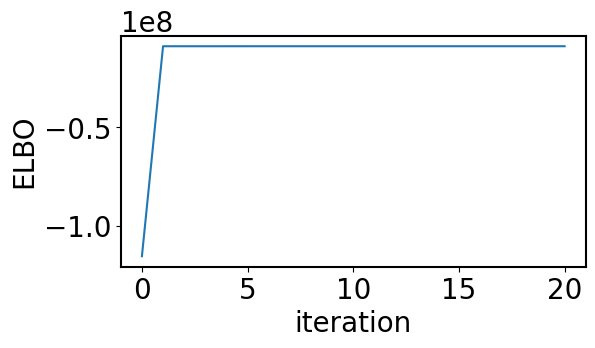

In [82]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

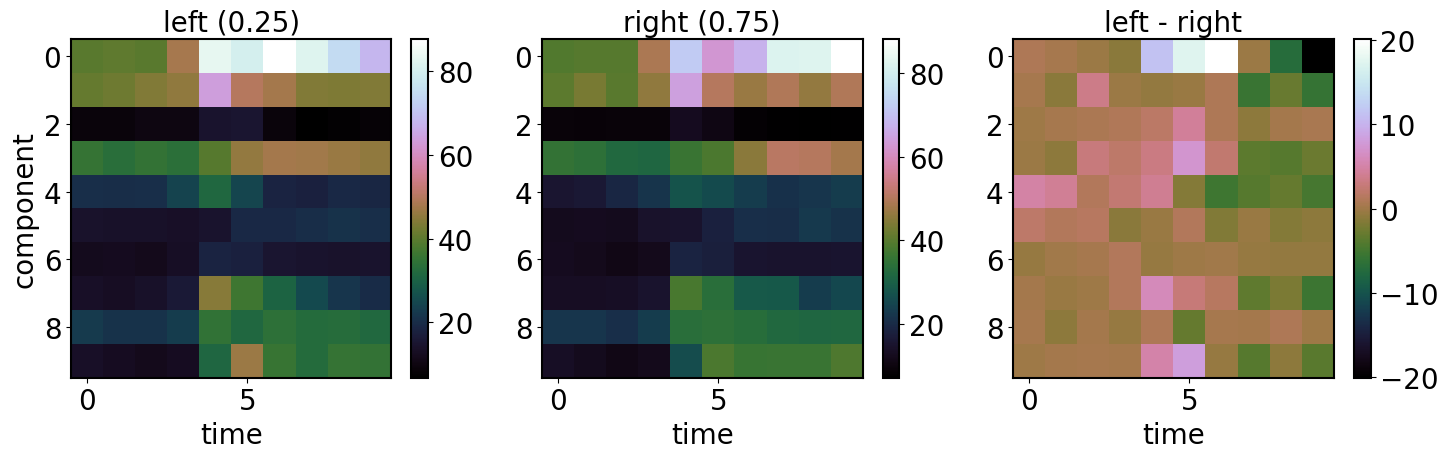

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(enc_lam[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left ({p:.2f})')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right ({1-p:.2f})')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(enc_lam[:,:,0] - enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()

In [91]:
dec_r, dec_nu, dec_mu, dec_cov, dec_p, dec_elbos = cavi.decode(
    s = torch.tensor(test_trials),
    init_p = torch.tensor([p]), 
    init_mu = enc_mu, 
    init_cov = enc_cov, 
    init_lam = enc_lam, 
    test_k_ids = test_trial_ids, 
    test_ids = data_loader.test_ids, 
    max_iter=20
)

initial elbo: -31358364.86
iter: 1 elbo: -2185159.72.
iter: 2 elbo: -2183652.38.
iter: 3 elbo: -2183048.59.
iter: 4 elbo: -2182628.65.
iter: 5 elbo: -2182255.02.
iter: 6 elbo: -2181897.64.
iter: 7 elbo: -2181546.68.
iter: 8 elbo: -2181209.70.
iter: 9 elbo: -2180903.71.
iter: 10 elbo: -2180648.18.
iter: 11 elbo: -2180448.13.
iter: 12 elbo: -2180300.27.
iter: 13 elbo: -2180193.86.
iter: 14 elbo: -2180118.16.
iter: 15 elbo: -2180063.11.
iter: 16 elbo: -2180022.50.
iter: 17 elbo: -2179992.31.
iter: 18 elbo: -2179967.52.
iter: 19 elbo: -2179946.80.
iter: 20 elbo: -2179926.41.
reached max iter allowed.


#### eval

In [94]:
cavi.eval_performance(dec_nu, data_loader.y_test)

decoding accuracy is 0.85
decoding auc is 0.87


(0.8490566037735849, 0.8711538461538462)